In [1]:
import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.95'

In [2]:
import jax
import jax.numpy as np

key = jax.random.PRNGKey(1)

jax.config.update("jax_debug_nans", True)
jax.config.update("jax_enable_x64", True)

import jax_morph as jxm

import matplotlib.pyplot as plt

# Cell State

In [3]:
#all new cell states must inherit from jxm.BaseCellState
class CellState(jxm.BaseCellState):
    division:           jax.Array
    chemical:           jax.Array
    secretion_rate:     jax.Array
    chemical_grad:      jax.Array
    hidden_state:       jax.Array
    mechanical_stress:  jax.Array

In [4]:
N_DIM = 2
N_CHEM = 2
N_HIDDEN = 16

N = 200
N_ADD = int(N-1)


### Build initial state

disp, shift = jax_md.space.free()

istate = CellState(
    displacement=   disp,
    shift=          shift,
    position=       np.zeros(shape=(N,N_DIM)),
    celltype=       np.zeros(shape=(N,1)).at[0].set(1),
    radius=         np.zeros(shape=(N,1)).at[0].set(.5),
    division=       np.zeros(shape=(N,1)).at[0].set(1.),
    chemical=       np.zeros(shape=(N,N_CHEM)),
    chemical_grad=  np.zeros(shape=(N,int(N_DIM*N_CHEM))),
    secretion_rate= np.zeros(shape=(N,N_CHEM)).at[0].set(1.),
    mechanical_stress= np.zeros(shape=(N,1)),
    hidden_state=   np.zeros(shape=(N,N_HIDDEN))
)

# Stochastic Model

**NOTE:** Since the model is stochastic, the call will return both the new state and the logprobability of the cell division

In [5]:
key, init_key = jax.random.split(key)


mech_potential = jxm.env.mechanics.MorsePotential(epsilon=3., alpha=2.8)

model = jxm.Sequential(
    substeps=[
        jxm.env.CellDivision(),

        jxm.env.CellGrowth(growth_rate=.03, max_radius=.5, growth_type='linear'),

        jxm.env.mechanics.SGDMechanicalRelaxation(mech_potential),

        jxm.env.SteadyStateDiffusion(degradation_rate=.1, diffusion_coeff=.2),

        jxm.cell.sensing.LocalChemicalGradients(),

        jxm.cell.sensing.LocalMechanicalStress(mech_potential),

        jxm.cell.GeneNetwork(istate,
                            input_fields=['chemical', 'chemical_grad', 'division', 'radius', 'mechanical_stress'],
                            output_fields=['secretion_rate', 'division'],
                            key=init_key,
                            transform_output={'division': lambda s,x: x*jax.nn.sigmoid(50*(s.radius - .45))},
                            expr_level_decay=0.,
                            ),
    ])

## Advance one step

In [6]:
key, subkey = jax.random.split(key)
new_state, logp = model(istate, key=subkey)

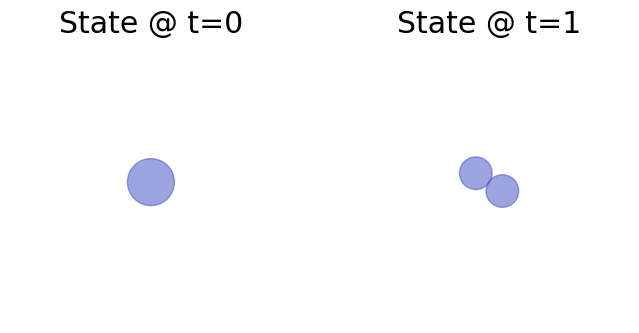

In [7]:
fig, axs = plt.subplots(1,2)

jxm.visualization.draw_circles_ctype(istate, ax=axs[0])
axs[0].set_title('State @ t=0')


jxm.visualization.draw_circles_ctype(new_state, ax=axs[1])
axs[1].set_title('State @ t=1');

# background to white
fig.patch.set_facecolor('white')
fig.patch.set_alpha(1.)

## Simulate trajectory

`jxm.simulate` automatically detects if the model should be treated as stochastic (i.e. returns the logprobabilities of the cell divisions) or not. In the last case it will return just the final state or the trajectory.

In [8]:
key, subkey = jax.random.split(key)
fstate, logps = jxm.simulate(model, istate, subkey, N_ADD)

In [9]:
logps

Array([  0.        ,  -1.38622291,  -0.01681192,  -1.99500954,
        -0.61583558,  -0.25496863,  -1.34196499,  -4.19538471,
        -2.20662979,  -2.8924678 ,  -2.30664388,  -3.53940799,
        -7.69743101,  -5.60157244,  -3.8747774 ,  -3.06037533,
        -3.91659876,  -3.92466037,  -4.19368563,  -5.43607262,
        -5.24442544,  -5.14599215,  -5.27318621,  -5.36404583,
        -5.53759014,  -5.83322843,  -7.66695084,  -5.93466298,
        -6.03296952,  -6.99762922,  -6.15025092,  -7.0869567 ,
        -6.28800236,  -6.2095809 ,  -6.31144011,  -6.45215617,
        -6.60822137,  -6.65482148,  -6.7535812 ,  -6.88970092,
        -6.87226712,  -6.93206783,  -7.00952623,  -7.04698397,
        -7.10185927,  -7.98592856,  -7.1220241 ,  -7.17391393,
        -8.9324944 ,  -7.56836906,  -7.38579152,  -7.47014875,
        -7.48264649,  -7.45099902,  -7.29790519,  -7.31133567,
        -7.43337451,  -7.62841184,  -7.69350427,  -7.74979739,
        -7.75289632,  -7.75215202,  -7.80498658,  -7.86

### Visualizations

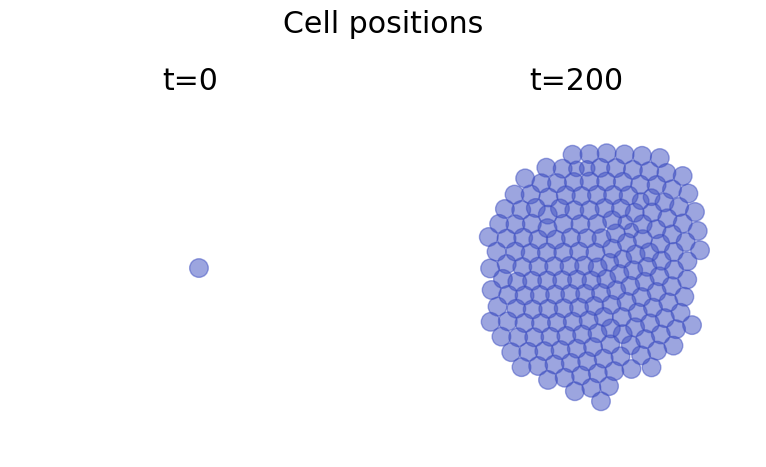

In [10]:
fig, axs = plt.subplots(1,2)
fig.suptitle('Cell positions', y=.8)


jxm.visualization.draw_circles_ctype(istate, ax=axs[0])
axs[0].set_title('t=0')

jxm.visualization.draw_circles_ctype(fstate, ax=axs[1])
axs[1].set_title(f't={N}');


#set same axis limits
axs[0].set_xlim(axs[1].get_xlim())
axs[0].set_ylim(axs[1].get_ylim())



# background to white
fig.patch.set_facecolor('white')
fig.patch.set_alpha(1.)
fig.tight_layout()

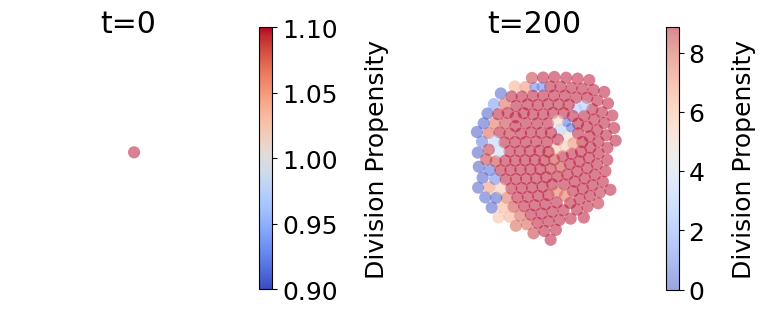

In [11]:
fig, axs = plt.subplots(1,2)


jxm.visualization.draw_circles_divrate(istate, ax=axs[0])
axs[0].set_title('t=0')


jxm.visualization.draw_circles_divrate(fstate, ax=axs[1])
axs[1].set_title(f't={N}')


#set same axis limits
axs[0].set_xlim(axs[1].get_xlim())
axs[0].set_ylim(axs[1].get_ylim())



# background to white
fig.patch.set_facecolor('white')
fig.patch.set_alpha(1.)
fig.tight_layout()

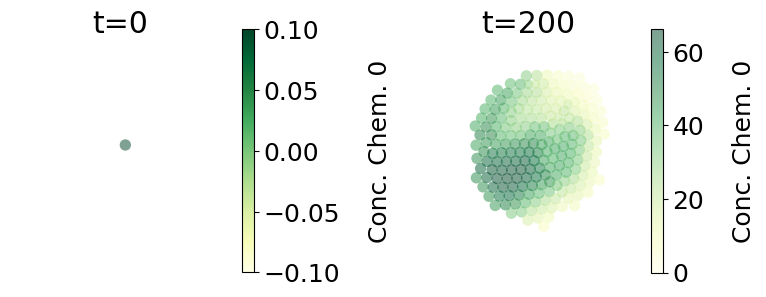

In [12]:
fig, axs = plt.subplots(1,2)


jxm.visualization.draw_circles_chem(istate, chem=0, ax=axs[0])
axs[0].set_title('t=0')


jxm.visualization.draw_circles_chem(fstate, chem=0, ax=axs[1])
axs[1].set_title(f't={N}')


#set same axis limits
axs[0].set_xlim(axs[1].get_xlim())
axs[0].set_ylim(axs[1].get_ylim())



# background to white
fig.patch.set_facecolor('white')
fig.patch.set_alpha(1.)
fig.tight_layout()

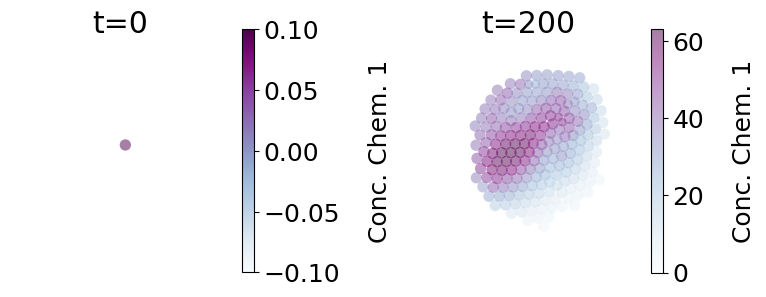

In [13]:
fig, axs = plt.subplots(1,2)


jxm.visualization.draw_circles_chem(istate, chem=1, ax=axs[0])
axs[0].set_title('t=0')


jxm.visualization.draw_circles_chem(fstate, chem=1, ax=axs[1])
axs[1].set_title(f't={N}')


#set same axis limits
axs[0].set_xlim(axs[1].get_xlim())
axs[0].set_ylim(axs[1].get_ylim())



# background to white
fig.patch.set_facecolor('white')
fig.patch.set_alpha(1.)
fig.tight_layout()

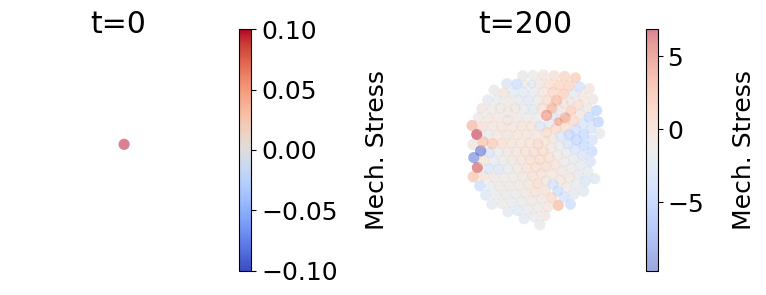

In [14]:
fig, axs = plt.subplots(1,2)


jxm.visualization.draw_circles_stress(istate, ax=axs[0])
axs[0].set_title('t=0')


jxm.visualization.draw_circles_stress(fstate, ax=axs[1])
axs[1].set_title(f't={N}')


#set same axis limits
axs[0].set_xlim(axs[1].get_xlim())
axs[0].set_ylim(axs[1].get_ylim())



# background to white
fig.patch.set_facecolor('white')
fig.patch.set_alpha(1.)
fig.tight_layout()